<a href="https://colab.research.google.com/github/jafr0822/MNA_ProyectoIntegrador-Equipo7/blob/main/Avance2_Equipo7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto Integrador


## Tecnológico de Monterrey
### Maestría en Inteligencia Artificial Aplicada (MNA)
#### Avance 2
#### Equipo 7


* Jorge Arturo Federico Rivera – A01250724
* Marco Antonio Vázquez Morales – A01793704
* Alejandro Jesús Vázquez Navarro - A01793146

### Ingeniería de Características

Proyecto:

*Modelo clasificador de multimorbilidad maternal y predictor de desenlaces perinatales a partir de datos clínicos metabólicos, genéticos y nutricionales de mujeres mexicanas*

12 de mayo de 2024

# 1. Construcción

Tomaremos el dataframe `dfPreparado` que preparamos en la **Fase I**, aplicaremos la construcción de la variable dependiente y la inclusión de nuevas características. Por ejemplo, la variable `prematurez` se basará en el número de semanas de la variable `sdg_parto`.

A continuación las reglas de creación de características:

- **Prematurez** [variable nueva] En función al valor de la variable `sdg_parto` se determinará si el valor es **1** o **0**. La regla es: Si el valor es menor a 36, entonces será prematuro (1), caso contrario el valor será no prematuro (0).
- **EscalaRiesgo** [variable dependiente] Clasificación que tomará como base la suma de '1' en las 8 características indicadas por el cuerpo médico + nueva característica: `prematurez`. Con base en este valor, obtendremos los siguientes valores:
  - **A**: Alto riesgo: Puntuación 3 y 4
  - **B**: Medio riesgo: Puntuación entre 1 y 2
  - **C**: Bajo Riesgo: Puntuación 0

- **Clúster asociado** Después de correr un algoritmo de clustering, agregaremos al dataframe _dfPreparado_ el número de clúster asociado.

Además, crearemos variables con one hot encoding para la variable `macrosomia_rn`. Dicha variable tiene un vector de valores que comprende ratios, por ejemplo: 1/0 y 0/0


### 1.1. Funciones ad hoc

In [ ]:
def definePrematurez(sdg_parto):
  if sdg_parto > 36:
    return 0
  else:
    return 1

def defineClase(valor_IndexMorbilidad):
  if valor_IndexMorbilidad ==3 or valor_IndexMorbilidad==4:
    return "A"
  elif valor_IndexMorbilidad ==1 or valor_IndexMorbilidad==2:
    return "B"
  else:
    return "C"

def identify_binary(data):

  binary_cols = []
  for col in data.columns:
    unique_values = data[col].dropna().unique()
    #print(f'Col name {col} unique values {unique_values}')

    if len(unique_values) == 2 and (set(unique_values) == {0, 1}):

      binary_cols.append(col)
  return binary_cols

### 1.2 Librerías

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_samples, silhouette_score

# Para el clustering
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


### 1.3 Carga de datos

In [ ]:
# Adquisisicón de datos

dfPreparado = pd.read_csv("data/dataset_proxima_fase.csv", encoding='utf8')
dfIds = dfPreparado[['id_gdg', 'origen_px']]
dfPreparado.head()

,id_gdg,origen_px,biopsias,obs_h,ichos_pregesta,hta_pregesta,sop,hipotiroidismo,hipertiroidismo,consumo_alcohol,...,peso_3,sdg_dx,no_gestas,sdg_parto,peso_2,supl_1erTrim,ldl_dx,modo_parto,macrosomia_rn,anticonceptivo
0,DG37D44,DF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,72.554037,2.0,3.0,37.452049,68.963291,0.843066,113.255088,0.0,1,0.0
1,DG28M97,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,72.554037,1.0,2.0,37.452049,68.963291,0.843066,113.255088,0.0,1,0.0
2,DG73R77,NaN,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,72.554037,0.0,2.0,37.452049,68.963291,0.843066,113.255088,1.0,1,0.0
3,DG63E13,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,72.554037,0.0,2.0,37.452049,68.963291,0.843066,113.255088,1.0,1,0.0
4,DG61O38,Guerrero,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,72.554037,0.0,4.0,37.452049,68.963291,0.843066,113.255088,1.0,1,0.0


### 1.4 Variable Prematurez

In [ ]:
dfPreparado["prematurez"] = dfPreparado['sdg_parto'].apply(lambda x:definePrematurez(x))

#### 1.4.1 Revisar distribución de la nueva variable.


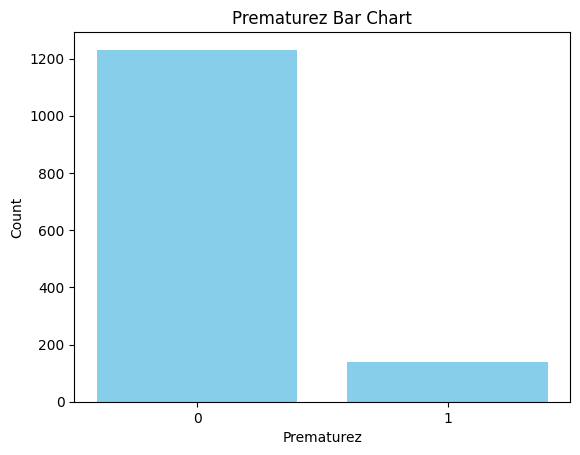

In [ ]:
prematurez_counts = dfPreparado['prematurez'].value_counts()
prematurez_counts = prematurez_counts.sort_index()
plt.bar(prematurez_counts.index, prematurez_counts.values, color='skyblue')
plt.xticks(list(map(int, prematurez_counts.index)))

plt.title('Prematurez Bar Chart')
plt.xlabel('Prematurez')
plt.ylabel('Count')
plt.show()

### 1.5 Variable dependiente

In [ ]:
lst_IndexMorbilidad = ['malformaciones_rn', 'aborto_rn','obito_rn','mnt_rn','preeclampsia', 'polihidramnios', 'hidramnios', 'infeccion_gesta', 'prematurez']
dfPreparado["IndexMorbilidad"] = dfPreparado[lst_IndexMorbilidad].sum(axis=1)
dfPreparado["EscalaRiesgo"] =  dfPreparado['IndexMorbilidad'].apply(lambda x:defineClase(x))


#### 1.6 Revisar la distribución de la variable dependiente **EscalaRiesgo**

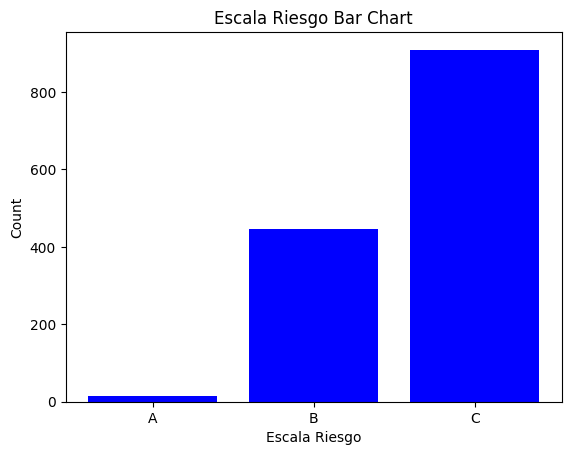

In [ ]:
escala_riesgo = dfPreparado['EscalaRiesgo'].value_counts()
escala_riesgo = escala_riesgo.sort_index()
plt.bar(escala_riesgo.index, escala_riesgo.values, color='blue')
plt.title('Escala Riesgo Bar Chart')
plt.xlabel('Escala Riesgo')
plt.ylabel('Count')
plt.show()

In [ ]:
dfPreparado.to_csv("test.csv")

# 2. Normalización

En esta fase, realizaremos escalamiento de las variables numéricas pues, derivado del análisis de la **Fase 1** encontramos diferentes outliers que pueden desestabilizar el modelo base y subsecuentes.

Utilizaremos un Pipeline para crear la canalización para aplicar las transformaciones pertinentes.


In [ ]:
binary_features = identify_binary(dfPreparado)

all_cols = set(dfPreparado.columns)
cols_to_remove_from_numeric =["macrosomia_rn", "id_gdg", "origen_px"]

numeric_features = [x for x in all_cols if x not in binary_features]
numeric_features = [x for x in numeric_features if x not in cols_to_remove_from_numeric]
numeric_features.remove("IndexMorbilidad")
numeric_features.remove("EscalaRiesgo")
numeric_features.remove("anticonceptivo")

categorical_features  =["macrosomia_rn", "anticonceptivo"]

print(binary_features)

['biopsias', 'obs_h', 'ichos_pregesta', 'hta_pregesta', 'sop', 'hipotiroidismo', 'hipertiroidismo', 'consumo_alcohol', 'consumo_tabaco', 'ah_dm', 'ah_hta', 'ah_ob', 'ah_dg', 'ant_dg', 'ant_obito', 'ant_mnt', 'ant_malformado', 'ant_macrosomico', 'cesarea_iter', 'ema', 'estatura_baja', 'pgr', 'infeccion_pregesta', 'embarazo_multiple', 'preeclampsia', 'polihidramnios', 'hidramnios', 'infeccion_gesta', 'ac_fol_pregesta', 'malformaciones_rn', 'aborto_rn', 'obito_rn', 'mnt_rn', 'tiene_pareja', 'paciente_trabaja', 'AcFolico_supl', 'supl_preconcep', 'AcFolico_papa', 'prematurez']


In [ ]:

# Create pipeline for preprocessing
binary_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing values with mode
    ('binarizer', FunctionTransformer(lambda x: x.astype(bool), validate=False))  # Convert to binary
])

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())  # Scale numerical features if needed
])

categorical_transformer = Pipeline(steps=[

    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # Encode categorical variables
])

preprocessor = ColumnTransformer(
    transformers=[
        ('binary', binary_transformer, binary_features),
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create the pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])
pipeline.fit(dfPreparado)

# Fit and transform the data
transformed_data = pipeline.transform(dfPreparado)


# Get feature names
binary_feature_names = binary_features
numeric_feature_names = numeric_features
categorical_feature_names = pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
feature_names = binary_feature_names + numeric_feature_names + list(categorical_feature_names)

transformed_df = pd.DataFrame(transformed_data, columns=feature_names)
transformed_df.to_csv("final.csv")

# 3. Selección / Extracción

En esta fase incluiremos la evaluación por clustering y agregaremos como característica de identificación el cluster identificado.

Esto se realiza hasta esta fase debido a que se procesaron, imputaron y escalaron primero los datos.



### 3.1 Evaluación del número óptimo de clústers

De acuerdo a esta primera evaluación, es posible apreciar que **3** es el número adecuado de clusters para el dataset. Podemos ver cómo la curva "rompe" en el cluster 3. Confirmaremos nuestra hipótesis con la gráfica de silueta.

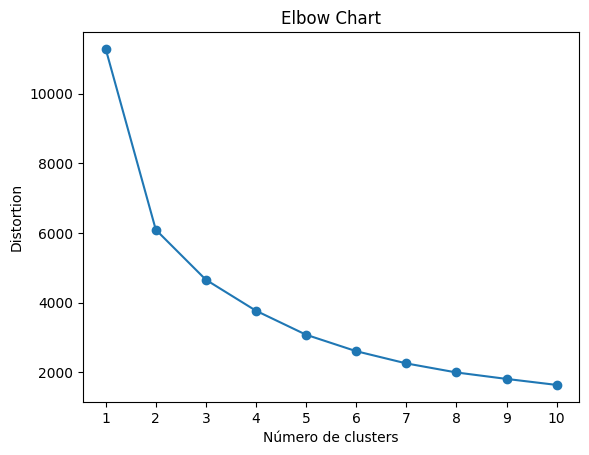

In [ ]:

pca = PCA(n_components=2)
pca.fit(transformed_df)
df_pca = pca.transform(transformed_df)


distortions = []
for i in range(1, 11):  # Test cluster numbers from 1 to 10
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(df_pca)
    distortions.append(kmeans.inertia_)


plt.plot(range(1, 11), distortions, marker='o')
plt.title('Elbow Chart')
plt.xlabel('Número de clusters')
plt.ylabel('Distortion')
plt.xticks(range(1, 11))
plt.show()



Ahora la gráfica de clustering:

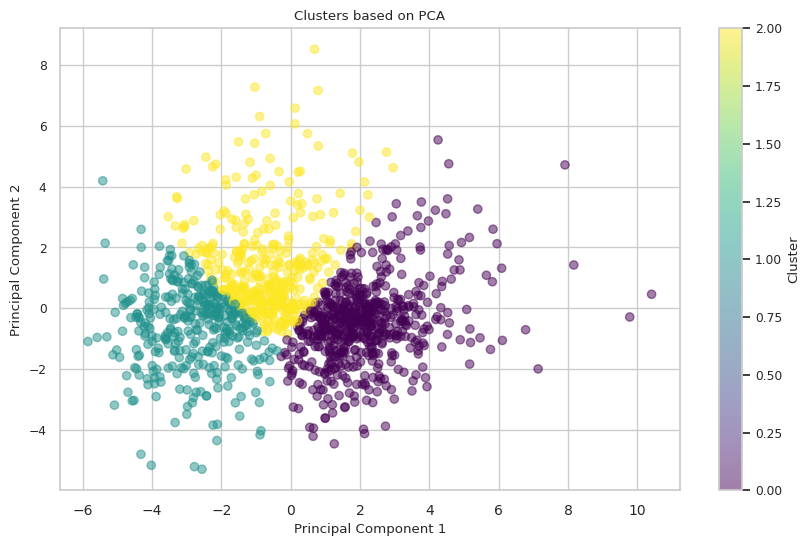

In [ ]:

optimal_num_clusters = 3


kmeans = KMeans(n_clusters=optimal_num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(df_pca)


plt.figure(figsize=(10, 6))
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=cluster_labels, cmap='viridis', alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Clusters based on PCA')
plt.colorbar(label='Cluster')
plt.show()

En este código evaluamos el score de silueta para entender qué tan bien están clasificados los puntos de acuerdo al número de clúster.

- **Valores cercanos a 1:** Puntos bien clasificados y cercanos al centroide de grupo.
- **Valores cercanos a 0:** Puntos entre el límite de 2 clusters
- **Valores cercanos a -1:** Puntos mal clasificados y alejados del centroide de grupo.

En este sentido, 2 clústers nos dan la mejor pertenencia. Sin embargo, agrupar por 3 tiene es más armónico con la variable dependiente `EscalaRiesgo`

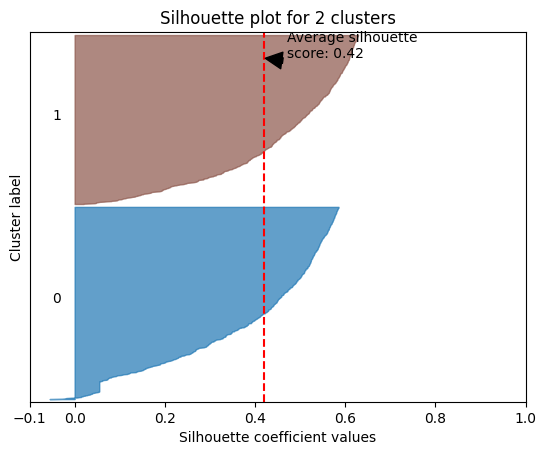

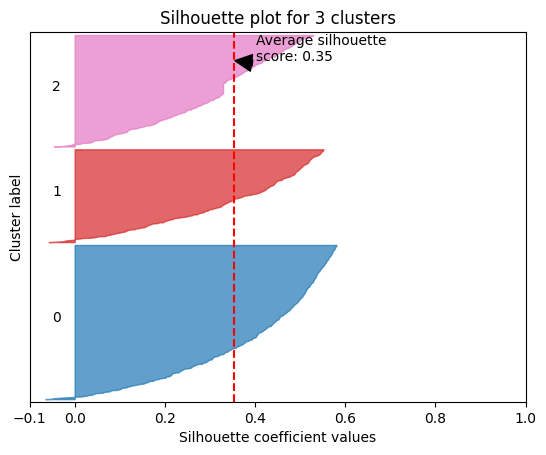

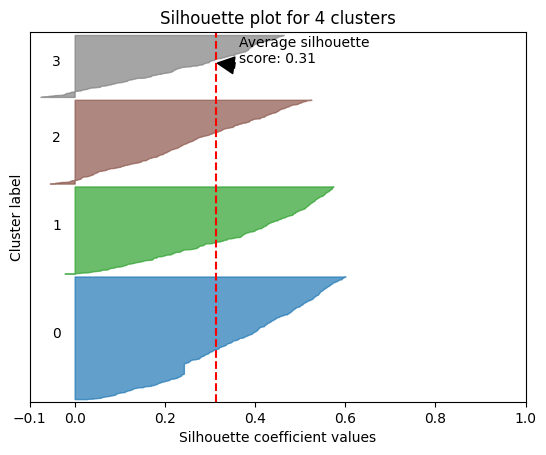

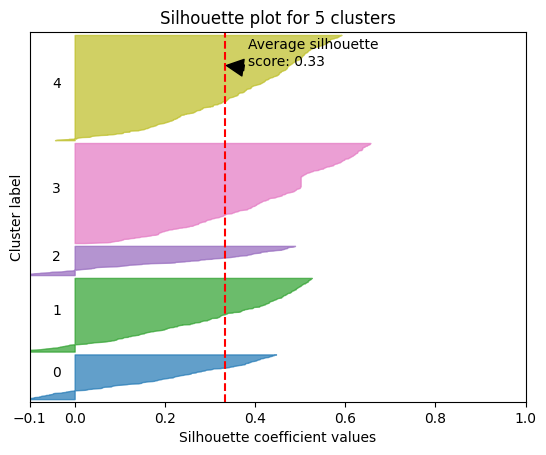

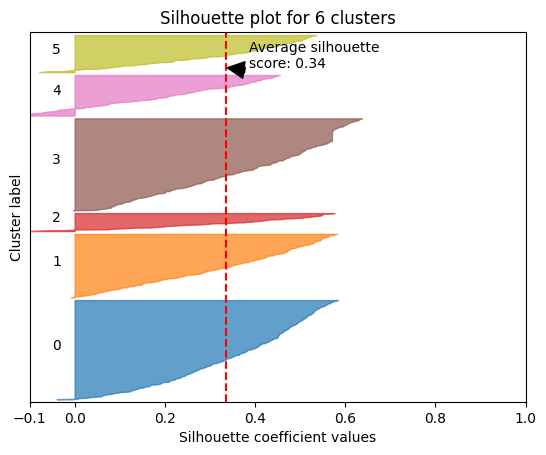

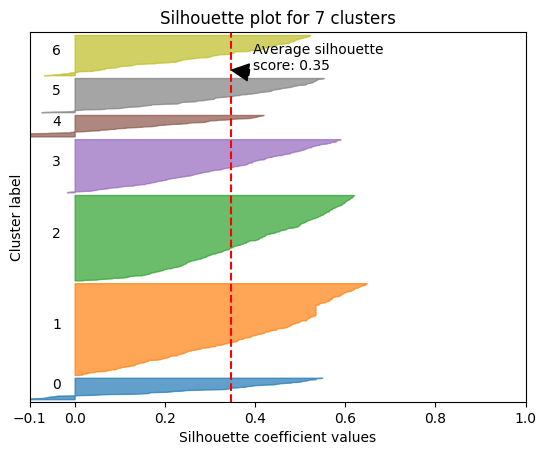

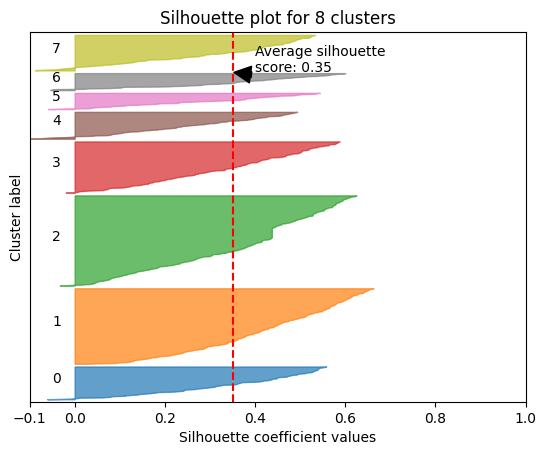

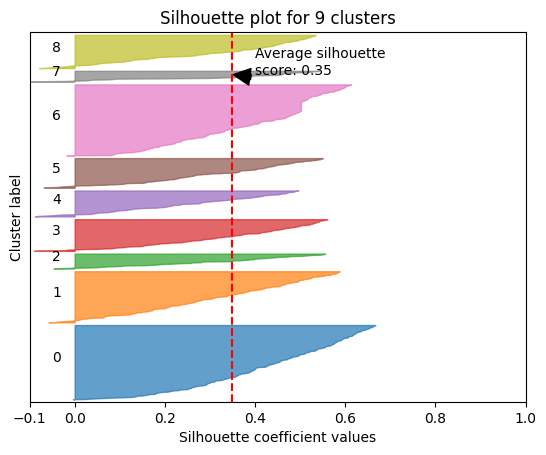

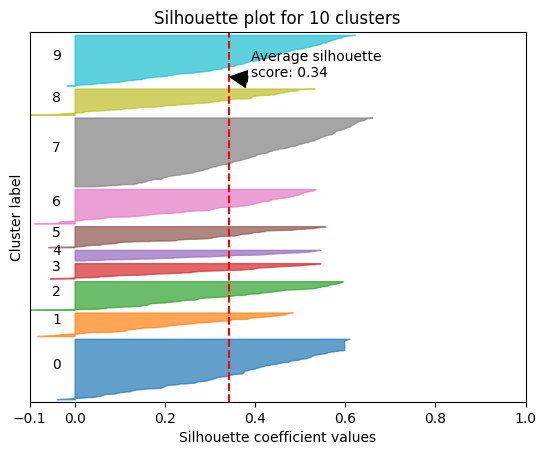

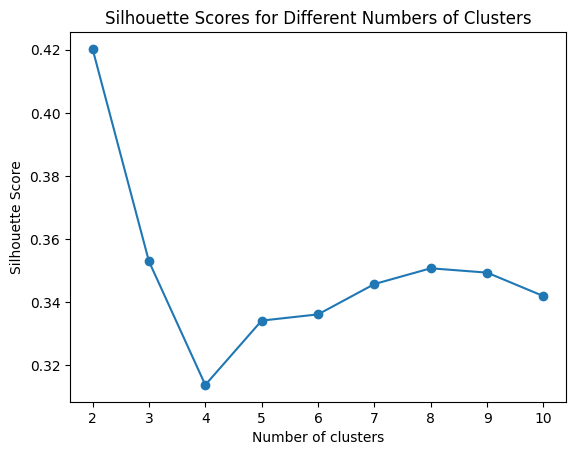

In [ ]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]
silhouette_scores = []

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(df_pca)

    silhouette_avg = silhouette_score(df_pca, cluster_labels)
    silhouette_scores.append(silhouette_avg)

    sample_silhouette_values = silhouette_samples(df_pca, cluster_labels)

    fig, ax = plt.subplots()
    ax.set_xlim([-0.1, 1])
    ax.set_ylim([0, len(df_pca) + (n_clusters + 1) * 10])

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = plt.cm.tab10(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title("Silhouette plot for {} clusters".format(n_clusters))
    ax.set_xlabel("Silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    ax.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax.annotate('Average silhouette\nscore: {:.2f}'.format(silhouette_avg), xy=(silhouette_avg, len(df_pca) * 0.95),
                xytext=(silhouette_avg + 0.05, len(df_pca) * 0.95),
                arrowprops=dict(facecolor='black', shrink=0.05))

    ax.set_yticks([])
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.show()


plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.title('Silhouette Scores for Different Numbers of Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.xticks(range_n_clusters)
plt.show()

### 3.2 Asignación del número de cluster a cada observacion

En esta parte del código, se asignará el número de cluster calculado a cada observación. Hemos definido **3** como el número ideal después de los análisis realizados.

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(transformed_df)


transformed_df['cluster'] = cluster_labels

# Agregar el id_gdg y origen_px para fines de visualización posterior

dfFinal = pd.concat([dfIds, transformed_df], axis=1)
dfFinal.to_csv("clusters.csv")


### 3.3 Identificación de componentes principales **(PCA)**

Con este análisis podremos identificar cuáles características suman información al modelo.

In [ ]:
pcs = PCA(n_components=85)

principalComponents = pcs.fit_transform(transformed_df)
scores_pca = pcs.transform(transformed_df)

pcsSummary = pd.DataFrame({'Standard deviation': np.sqrt(pcs.explained_variance_),
                          'Proportion of variance':pcs.explained_variance_ratio_,
                          'Cumulative proportion': np.cumsum(pcs.explained_variance_ratio_)#column
                          }
                          )
pcsSummary.round(4)


,Standard deviation,Proportion of variance,Cumulative proportion
0,2.4021,0.1520,0.1520
1,1.6772,0.0741,0.2261
2,1.6158,0.0688,0.2949
3,1.5386,0.0624,0.3572
4,1.4009,0.0517,0.4089
...,...,...,...
80,0.0283,0.0000,1.0000
81,0.0267,0.0000,1.0000
82,0.0265,0.0000,1.0000
83,0.0000,0.0000,1.0000


In [ ]:

loadings_df = pd.DataFrame(pcs.components_.T, columns=transformed_df.columns)
loadings_df

,biopsias,obs_h,ichos_pregesta,hta_pregesta,sop,hipotiroidismo,hipertiroidismo,consumo_alcohol,consumo_tabaco,ah_dm,...,macrosomia_rn_0/0,macrosomia_rn_1,macrosomia_rn_1.0,macrosomia_rn_1/0,macrosomia_rn_1/1,macrosomia_rn_2,anticonceptivo_0.0,anticonceptivo_1.0,anticonceptivo_2.0,cluster
0,-0.013111,0.016715,0.005187,0.013441,-0.013812,-0.005373,-0.036098,-0.005801,-0.002033,-0.006593,...,0.007621,-0.012692,-0.005527,0.000315,-0.009659,0.003912,0.000677,0.001051,2.289141e-16,0.000000e+00
1,0.048648,0.102718,0.000585,0.040674,0.033597,0.025542,0.025642,-0.017909,-0.013009,-0.035328,...,-0.003912,-0.003887,0.018092,-0.000160,-0.001231,0.000431,-0.002290,0.001059,-7.871177e-17,-7.733849e-17
2,0.002723,0.002691,0.004698,0.001923,0.000286,0.000903,0.002349,0.002689,-0.000277,-0.002767,...,-0.022989,-0.038149,0.024462,0.006303,0.004804,0.002321,-0.000528,0.002261,-8.534567e-16,-3.727542e-16
3,0.014916,0.013189,0.011223,-0.005827,0.013113,0.002705,0.007213,-0.009083,-0.003590,-0.030049,...,0.006404,-0.011079,-0.009596,-0.005263,0.002185,0.003179,0.001734,0.001986,2.955269e-17,1.107573e-16
4,0.000573,-0.000411,0.002531,0.002249,-0.004226,0.004058,-0.000048,0.000393,-0.003117,0.002690,...,0.019724,0.016250,-0.005104,0.002938,0.000800,-0.003121,0.002741,-0.001596,-2.791884e-16,2.406172e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,0.004458,0.001464,0.002612,0.001519,0.002156,-0.001537,0.005309,0.004285,-0.000477,0.001006,...,-0.209439,-0.143102,0.050596,-0.006852,-0.005376,-0.204414,-0.006857,-0.018461,-2.060007e-02,3.529527e-01
81,0.018751,0.018968,-0.031430,-0.021518,0.008400,0.038221,0.003269,-0.014030,-0.000549,-0.067459,...,0.001809,0.008141,0.005880,0.002883,-0.005236,-0.000989,-0.000407,0.000264,-5.763694e-01,-3.363977e-02
82,-0.014158,-0.016038,0.024166,0.012737,-0.016847,-0.016512,0.004902,0.013495,-0.007731,0.057695,...,-0.003543,0.000280,0.010297,0.003841,0.000491,0.000553,-0.000379,-0.000014,-5.763694e-01,-3.363977e-02
83,-0.004593,-0.002931,0.007265,0.008781,0.008447,-0.021709,-0.008171,0.000535,0.008280,0.009764,...,0.001734,-0.008421,-0.016178,-0.006724,0.004745,0.000436,0.000786,-0.000251,-5.763694e-01,-3.363977e-02


Con esta tabla podemos calcular fácilmente que:

- Hasta el componente **18** podemos acumular 81% del total de varianza

- Los componentes 0 y 1 son los que mayor valor aportan al dataset con 0.15 y 0.23 respectivamente.

Grafiquemos estos resultados para tener una mejor claridad de las cosas.

Como habíamos notado en el componente principal **18** acumulamos el **81%** sin embargo, por tratarse de un tema médico, aumentaremos nuestro umbral a **99%**. Encontramos que en el componente **51** alcanzamos este umbral.

### 3.4 **Insight**

Da mucho valor esta gráfica, pues partimos de una matriz transformada de 85 (menos 2 de identificación y estado de origen) columnas, ahora podemos quedarnos con solo 31 de estas características y facilitar el entrenamiento.

Como habíamos mencionado, hasta el componente **51** tenemos alrededor del **99%** de la varianza. Consideramos suficiente esta concentración de información para nuestros análisis.

Para completar el análisis de PCA, examinemos cada una de las variables para entender cuánto aportan de información a cada componente.

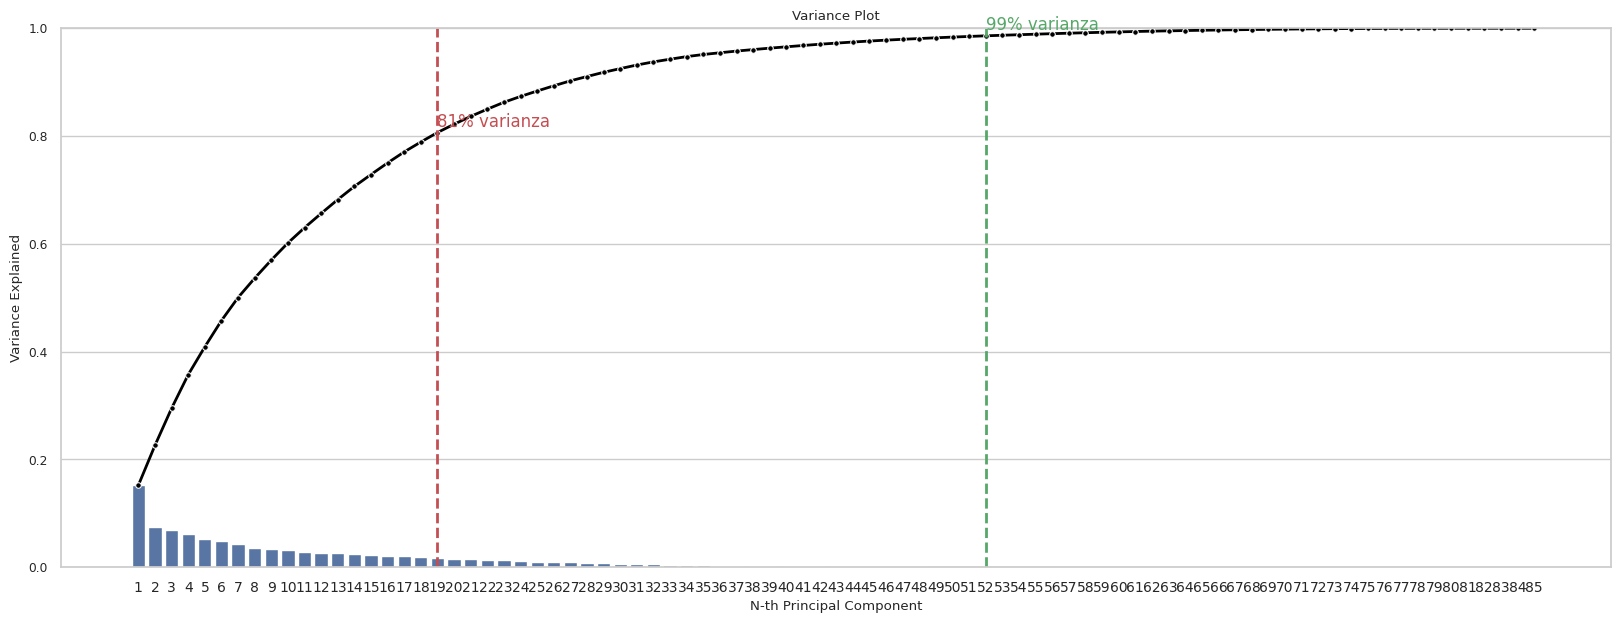

In [ ]:
# Hagamos una gráfica para representarlo y determinar el número mínimo de componentes:

import seaborn as sns

PC_components = np.arange(pcs.n_components_) + 1
#PC_components

_ = sns.set(style = 'whitegrid',
            font_scale = .8, rc={'xtick.labelsize': 10}
            )

fig, ax = plt.subplots(figsize=(20, 7))

_ = sns.barplot(x = PC_components,
                y = pcs.explained_variance_ratio_,
                color = 'b'
                )

_ = sns.lineplot(x = PC_components-1,
                 y = np.cumsum(pcs.explained_variance_ratio_),
                 color = 'black',
                 linestyle = '-',
                 linewidth = 2,
                 marker = 'o',
                 markersize = 4
                 )
plt.axvline(x=18, color='r', linestyle='--', linewidth=2)
plt.text(18, 0.81, "81% varianza", color='r', fontsize=12, verticalalignment='bottom')
# Add a vertical line at x=30 (for example)
plt.axvline(x=51, color='g', linestyle='--', linewidth=2)

# Add text "99% varianza" at x=30
plt.text(51, 0.99, "99% varianza", color='g', fontsize=12, verticalalignment='bottom')

plt.title('Variance Plot')
plt.xlabel('N-th Principal Component')
plt.ylabel('Variance Explained')
plt.ylim(0, 1)
plt.show()

# Conclusiones

Una vez realizada la primera fase del proyecto, consistente en el entendimiento del negocio, pasamos a la etapa de limpieza, escalado e imputación de los datos. En esta fase nos quedamos con 76 variables de los 99 originales, se creó una nueva variable llamada prematurez, la cual se agrega al nuevo conjunto de variables.

Al no tener una variable dependiente única, decidimos crear un índice de morbilidad, este índice lo que busca es ser un indicador de riesgo, y toma como base las variables “malformaciones_rn”, “aborto_rn”,”obito_rn”,”mnt_rn”,”preeclampsia”, “polihidramnios”, “hidramnios”, “infección_gesta”, “prematurez”. Como se observa, se incluye la nueva variable creada “prematurez”.

Al índice se le agregó una escala de riesgo denotada con “A” para Alto Riesgo, “B” para Riesgo Medio y “C” para Bajo Riesgo. Graficamos la escala de riesgo y nos muestra una baja proporción de alto riesgo, una proporción media de “Medio Riesgo” y una proporción grande de “Bajo Riesgo”.

Derivado de outliers se realizó un proceso de escalamiento a fin de normalizar las variables y con ello poder tener mejores resultados.

Aplicamos una reducción de dimensionalidad a fin de tener mejores datos para el entrenamiento de un modelo de clasificación pues a mayor número de características, mayor complejidad computacional, es decir, se requerirá recursos informáticos y por lo tanto mayor tiempo de entrenamiento. El resultado de esto fue que 3 sería el mejor número de clúster para aplicar, lo cual se comprobó con la curva Elbow.

Con la técnica Principal Component Analysis identificamos cuantos componentes necesitamos para lograr el mejor resultado, encontramos que para lograr el 99% se requiere hasta el 51 componente y para determinar el mínimo serían 18 alcanzando un 81%.

Dado que la metodología CRIPS es iterativa, podremos revisitar esta fase para experimentar con otros algoritmos de reducción de características.



